# Here he usefulness of matrix completion in 16S rRNA studies is demonstrated through three seperate studies of varying size. 

# Theese Data sets were chosen for bieng previously described as machine leanring challange data sets. 

## [Source of data set selection](http://onlinelibrary.wiley.com/doi/10.1111/j.1574-6976.2010.00251.x/full)

## 88 Soils (case study also included)


#### Soils harbor enormously diverse bacterial populations, and soil bacterial communities can vary greatly in composition across space. However, our understanding of the specific changes in soil bacterial community structure that occur across larger spatial scales is limited because most previous work has focused on either surveying a relatively small number of soils in detail or analyzing a larger number of soils with techniques that provide little detail about the phylogenetic structure of the bacterial communities. Here we used a bar-coded pyrosequencing technique to characterize bacterial communities in 88 soils from across North and South America, obtaining an average of 1,501 sequences per soil. We found that overall bacterial community composition, as measured by pairwise UniFrac distances, was significantly correlated with differences in soil pH (r = 0.79), largely driven by changes in the relative abundances of Acidobacteria, Actinobacteria, and Bacteroidetes across the range of soil pHs. In addition, soil pH explains a significant portion of the variability associated with observed changes in the phylogenetic structure within each dominant lineage. The overall phylogenetic diversity of the bacterial communities was also correlated with soil pH (R2 = 0.50), with peak diversity in soils with near-neutral pHs. Together, these results suggest that the structure of soil bacterial communities is predictable, to some degree, across larger spatial scales, and the effect of soil pH on bacterial community composition is evident at even relatively coarse levels of taxonomic resolution.


### P.I. Noah Fierer (University of Colorado) (Lauber et al.)
### [Data and Source](https://qiita.ucsd.edu/study/description/103)


## Fierer  

#### Recent work has demonstrated that the diversity of skin-associated bacterial communities is far higher than previously recognized, with a high degree of interindividual variability in the composition of bacterial communities. Given that skin bacterial communities are personalized, we hypothesized that we could use the residual skin bacteria left on objects for forensic identification, matching the bacteria on the object to the skin-associated bacteria of the individual who touched the object. Here we describe a series of studies de-monstrating the validity of this approach. We show that skin-associated bacteria can be readily recovered from surfaces (including single computer keys and computer mice) and that the structure of these communities can be used to differentiate objects handled by different individuals, even if those objects have been left untouched for up to 2 weeks at room temperature. Furthermore, we demonstrate that we can use a high-throughput pyrosequencing-based ap-proach to quantitatively compare the bacterial communities on objects and skin to match the object to the individual with a high degree of certainty. Although additional work is needed to further establish the utility of this approach, this series of studies introduces a forensics approach that could eventually be used to independently evaluate results obtained using more traditional forensic practices.

### P.I. Noah Fierer (University of Colorado) (Fierer et al.) 
### [Data and Source](https://qiita.ucsd.edu/study/description/232)



## Sponges (case study)


#### A comprehensive analysis of microbial symbiont communities associated with 82 species from the phylum Porifera


### P.I.  Torsten Thomas (University of New South Wales)
### [Data and Source](https://qiita.ucsd.edu/study/description/10346)

# Import libraries

In [1]:
from __future__ import division
#parsing command line
import argparse
import os
import re
#low rank methods (new)
from wpca import WPCA, EMPCA
#pcoa
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from warnings import warn
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
#PCA
from sklearn.decomposition import PCA
#machine leanring
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from skbio.stats.composition import clr
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.font_manager
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from collections import Counter
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from skbio.stats.composition import ilr
from scipy.stats import spearmanr
import itertools
#visual
from Impute_vis import PCA_niche
import seaborn as sns
import pylab
import matplotlib
import brewer2mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#other util
import sys
from gneiss.util import match
import scipy
import pandas as pd
import numpy as np
from scipy import stats, optimize
from biom import load_table
import operator
import copy
import warnings
#matrix completion
from fancyimpute import SoftImpute, IterativeSVD
#plt.style.use('bmh')

Using TensorFlow backend.


# Define functions

In [2]:
def convert_biom_to_pandas(table): # covert biom
    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,index=table.ids(axis='sample'),columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    for key, value in mapping.items():
        nvalue = ';'.join(value[1:])
        mapping.update({key:nvalue})
    taxonomy = pd.DataFrame(mapping, index=['taxonomy']).T
    return feature_table, taxonomy

### Source:

Biom to pandas dataframe code:

Jamie Morton, gneiss, (2016), GitHub repository, https://github.com/biocore/gneiss


# Supervised Machine Leanring 


<img src="etc/supervised_learning.jpg">



## Machine learning on 16S data is hard due to the low-density and spurious data.

### To overcome this problem we use matrix completion

### Matrix Completion Through Nuclear Norm Minimization 

#### Assume

$M = L_{0} + S_{0}$

$L_{0}$ is a Low-rank matrix

$S_{0}$ is a Sparse spikes noise matrix


Not only can this problem be solved, it can be solved by tractable convex optimization. 


Let $ ||M||_{*} := \sum_{i}σ_{i}(M)$ denote the nuclear norm of the matrix M, 

i.e. the sum of the singular values of M

Let $ ||M||_{1} := \sum_{ij}||M||_{ij}$ denote the 1-norm of M seen as a long vector in R n1×n2

Then it can be shown that the Principal Component Pursuit (PCP) estimate solving


Minimize $ ||L||_{*} + λ||S||_{1}$

Subject to $L + S = M$

It can be shown that this exactly recovers the low-rank $L_{0}$ and the sparse $S_{0}$. Theoretically, this is guaranteed to work even if the rank of $L_{0}$ grows almost linearly in the dimension of the matrix, and the errors in $S_{0}$ are up to a constant fraction of all entries.

#### source


Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Papanicolaou Alex, RPCA, (2011), GitHub repository, https://github.com/apapanico/RPCA


### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

### Impute the unknown values in the data using SoftImpute from FancyImpute 

##### soft Impute
[softImpute](https://web.stanford.edu/~hastie/swData/softImpute/vignette.html)

##### Fancy Impute
[ Fancy Impute](https://github.com/hammerlab/fancyimpute)


# Unsupervised Machine Leanring 

<img src="etc/supervised_learning.jpg">

### We will run supervised machine leanring for three seperate datasets, for a total of four different classifiers.

Cross-validation is done through an avrage score of ten itteration of splitting (80:20,train:test) and leanring.


# Comparing low-rank completed matrix to orginal matrix run on machine leanring state of the art Random Forests

In [61]:
files_to_run={'data/benchmarking/FSH_labels.txt':'data/benchmarking/FSH_otus.txt','data/benchmarking/CSS_labels.txt':'data/benchmarking/CSS_otus.txt','data/benchmarking/88_soils.txt':'data/benchmarking/88_soils.biom'}
chk_j=0
for map_file,in_biom in files_to_run.items():
    print('importing mapping file %s'%map_file)
    print('importing biom file %s'%in_biom)
    txlvl=6 #taxa level to work with
    mapstart_num=0 #starting metadata col

    ########################### metadata classification ##########################################################
    mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
    # re-name and set labels for ml 
    if 'CSS' == str(map_file.split('/')[-1].split('_')[0]):
        mappingdf.columns=['Costello $et\,al.$ Skin Sites (CSS)']
        to_run=['Costello $et\,al.$ Skin Sites (CSS)']        
    elif 'FSH' == str(map_file.split('/')[-1].split('_')[0]):        
        mappingdf.columns=['Fierer $et\,al.$ Subject × Hand (FSH)']
        to_run=['Fierer $et\,al.$ Subject × Hand (FSH)']             
    elif 'soil' == str(map_file.split('/')[-1].split('_')[0]):
        mappingdf = mappingdf[['pH','Annual Season Precipitation']] 
        mappingdf.columns=[['pH ( Lauber $et \, al.$)','Annual Season Precipitation']]
        to_run=['pH ( Lauber $et \, al.$)']

    mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
    if min(mappingdf.shape)<=0:
        sys.exit('Import error from mapping or metadata (less than two samples or features): please check your metadata is tab delimited format')

    ############################# import otu information ###################################################



    try:
        filename=in_biom.split('/')[-1]
    except:
        filename=in_biom

    if filename.split('.')[-1]=="biom":
        #BIOM
        #load table
        total_number_seq_sample=0 # make sure no zero sum samples
        total_number_seq_features=0 # make sure no zero sum otus 
        table = load_table('%s'%in_biom)
        read_filter1 = lambda val, id_, md: sum(val) > total_number_seq_sample
        read_filter2 = lambda val, id_, md: sum(val) > total_number_seq_features
        table.filter(read_filter1, axis='sample')
        table.filter(read_filter2, axis='observation')
        otu, taxonomy = convert_biom_to_pandas(table)
        otu=otu.T
        otu=otu.replace(np.nan,0, regex=True)
        #add taxa names
        taxa_names=list(taxonomy['taxonomy'])
    elif filename.split('.')[-1]=="csv" or filename.split('.')[-1]=="tsv" or filename.split('.')[-1]=="txt":
        #csv
        otu=pd.read_table('%s'%in_biom, index_col=0)
        otu=otu.T
        taxa_names=list(otu.index.values)
        otu=otu.replace(np.nan,0, regex=True)
        if min(otu.shape)<=1:
            sys.exit('Import error less than two samples or features: please check that your data is tab delimited or in biom file format')
    else:
        sys.exit('Import error: please check that your data is one of the following file formats (.csv,.biom,.txt,.tsv)')

    #add unque taxa names for pca/machine leanring (save taxa name for later)
    tax_index=[]
    otus_index=[]
    for q in range(0,len(otu.index.values)):
        otus_index.append("OTU_%s"%str(q))
    otu['new_index']=otus_index
    otu = otu.set_index('new_index')

    #### match and save data #####
    otu, mappingdf = match(otu.T, mappingdf)
    otu=otu.T

    #set taxa names ro level specified by user
    if txlvl==42:
        tax_index=otus_index
    else:
        for t in taxa_names:
            tax_index.append(";".join(t.split(";")[:txlvl]))

    #remove otus with sum to zero after matching files
    otu=otu.loc[(otu.sum(axis=1) != 0)]

    # save data, names and classifiers from data frame
    index = otu.index.values.tolist()
    data = otu.as_matrix()
    ids = otu.columns.values.tolist()
    ids = list(map(str, ids))

    # process taxa names
    tax_index_new=[]
    for cho in index:
        tax_index_new.append(tax_index[int(cho.split("_")[1])])
    tax_index=tax_index_new
    tax_index_new=[]
    #encode pre preoccessing from mapping
    samplenames = mappingdf.index.values.tolist()
    samplenames = map(str, samplenames)
    encoded_mapping={} #save coded and uncoded as dict
    encoded_mappingdf=mappingdf.copy() # encoded dataframe
    le = preprocessing.LabelEncoder() # encoder prepreocessing
    classifiers_meta=mappingdf.columns.values.tolist() # classifier names
    for metatmp in classifiers_meta[mapstart_num:]: # run each classifier
        le.fit(list(set(list(mappingdf[metatmp]))))
        encoded = le.transform(list(mappingdf[metatmp]))
        not_encoded = le.inverse_transform(encoded)
        encoded_mapping[metatmp]=[encoded,not_encoded]
        encoded_mappingdf[metatmp]=encoded #encoded dataframe

    otum=data.copy() # make copy for imputation
    otum=otum.astype(np.float64)
    otum[otum == 0] = np.nan #make unknown nan
    low_rank_matrix=SoftImpute(max_rank=min(otum.shape),max_iters=200,convergence_threshold=0.00001,min_value=0,max_value=(np.amax(otum)),verbose=False).complete(otum)

    
    sv={} # save scores for each classifier
    rng = np.random.RandomState(42)
    mapstart_num=0
    split_tmp=0
    for reduced_this in to_run:

        #remove all unknown samples for metadata column
        low_rank_matrix_matched,mappingdf_matched = match(pd.DataFrame(low_rank_matrix,index,ids).T,mappingdf) #filter data for unknowns
        mappingdf_matched_encoded,mappingdf_matched = match(encoded_mappingdf,mappingdf_matched)
        low_rank_matrix_matched=low_rank_matrix_matched.as_matrix()

        # run ten times
        crssval=[]
        q=0
        while q<=10:
            
            # split data
            X_train, X_test, y_train_all, y_test_all = train_test_split(low_rank_matrix.T.copy(),np.array(mappingdf_matched_encoded.as_matrix()),test_size=0.2,random_state=rng)
            #start machine learning
            metatmp=reduced_this
            check_tmp=0
            for check_occurance in list(set(encoded_mapping[metatmp][1])):
                if all(isinstance(item, str) for item in encoded_mapping[metatmp][1]) and check_tmp==0:
                    if list(encoded_mapping[metatmp][1]).count(check_occurance) <=1:
                        check_tmp+=1
                        print("    Warning: Skipping Catagory: %s contains labels that occurs only once, will cause spurious results."%(str(metatmp)))
                        continue

            y_train=y_train_all.T[split_tmp]
            y_test=y_test_all.T[split_tmp]
            if len(set(encoded_mapping[metatmp][0]))<=1: # can not learn classifiers with one label
                print("    Warning: Skipping Catagory: %s,  Catagory must have more than one label!"%str(metatmp))
                continue

            elif len(set(encoded_mapping[metatmp][0]))>2 and all(isinstance(item, str) for item in encoded_mapping[metatmp][1]): # if not quantity and class is not boolian
                clfm = RandomForestClassifier(random_state=rng) 
                clfm.fit(X_train, y_train)
                crssval.append(clfm.score(X_test, y_test))
            else: # if continous 
                clfr = RandomForestRegressor(random_state=rng) # grid search for optimized perams
                clfr.fit(X_train, y_train)
                crssval.append(clfr.score(X_test, y_test))
            q+=1
            
        #next column
        split_tmp+=1     
        #save mean score
        sv[metatmp] = np.mean(crssval)
        
        
    #Convert dict to dataframe and choose colors
    scores=pd.DataFrame(list(sv.items()))
    scores=scores.set_index(scores[0])
    scores=scores.drop([0], 1)
    scores.columns = ['Scores']
    scores.sort_values(['Scores'], ascending = [False], inplace = True)

    #machine leanring non-completed RF-RFE (best results from knights et al. 2011)
    sv={} # save scores for each classifier
    mapstart_num=0
    split_tmp=mapstart_num
    for reduced_this in to_run:

        #remove all unknown samples for metadata column
        data_matrix_matched,mappingdf_matched = match(pd.DataFrame(data,index,ids).T,mappingdf) #filter data for unknowns
        mappingdf_matched_encoded,mappingdf_matched = match(encoded_mappingdf,mappingdf_matched)
        data_matrix_matched=data_matrix_matched.as_matrix()

        # run ten times
        crssval=[]
        q=0
        while q<=10:
            
            # split data
            X_train, X_test, y_train_all, y_test_all = train_test_split(data.T.copy(),np.array(mappingdf_matched_encoded.as_matrix()),test_size=0.2,random_state=rng)
            #start machine learning
            metatmp=reduced_this
            check_tmp=0
            for check_occurance in list(set(encoded_mapping[metatmp][1])):
                if all(isinstance(item, str) for item in encoded_mapping[metatmp][1]) and check_tmp==0:
                    if list(encoded_mapping[metatmp][1]).count(check_occurance) <=1:
                        check_tmp+=1
                        print("    Warning: Skipping Catagory: %s contains labels that occurs only once, will cause spurious results."%(str(metatmp)))
                        continue

            y_train=y_train_all.T[split_tmp]
            y_test=y_test_all.T[split_tmp]
            if len(set(encoded_mapping[metatmp][0]))<=1: # can not learn classifiers with one label
                print("    Warning: Skipping Catagory: %s,  Catagory must have more than one label!"%str(metatmp))
                continue

            elif len(set(encoded_mapping[metatmp][0]))>2 and all(isinstance(item, str) for item in encoded_mapping[metatmp][1]): # if not quantity and class is not boolian
                clfm2 = RandomForestClassifier(random_state=rng) 
                clfm2.fit(X_train, y_train)
                crssval.append(clfm2.score(X_test, y_test))

            else: # if qauntity
                clfr2 = RandomForestRegressor(random_state=rng) # grid search for optimized perams
                clfr2.fit(X_train, y_train)
                crssval.append(clfr2.score(X_test, y_test))
            q+=1
            

        #next column
        split_tmp+=1     
        #save mean score
        sv[metatmp] = np.mean(crssval)
                
    #Convert dict to dataframe and choose colors
    scores_current = pd.DataFrame(list(sv.items()))
    scores_current=scores_current.set_index(scores_current[0])
    scores_current = scores_current.drop([0], 1)
    scores_current.columns = ['Scores']
    scores_current.sort_values(['Scores'], ascending = [False], inplace = True)
    #join
    if chk_j==0:
        result_both_scores=pd.concat([scores, scores_current], axis=1)
        result_both_scores.columns=['Matrix Completion (RF)','Original Data (RF)']
        chk_j+=1
    else:
        result_both_scores_to_add=pd.concat([scores, scores_current], axis=1)
        result_both_scores_to_add.columns=['Matrix Completion (RF)','Original Data (RF)']
        result_both_scores=pd.concat([result_both_scores, result_both_scores_to_add])

importing mapping file data/benchmarking/CSS_labels.txt
importing biom file data/benchmarking/CSS_otus.txt
importing mapping file data/benchmarking/soil_map.txt
importing biom file data/benchmarking/88_soils.biom
importing mapping file data/benchmarking/FSH_labels.txt
importing biom file data/benchmarking/FSH_otus.txt


# Machine Learning Results:

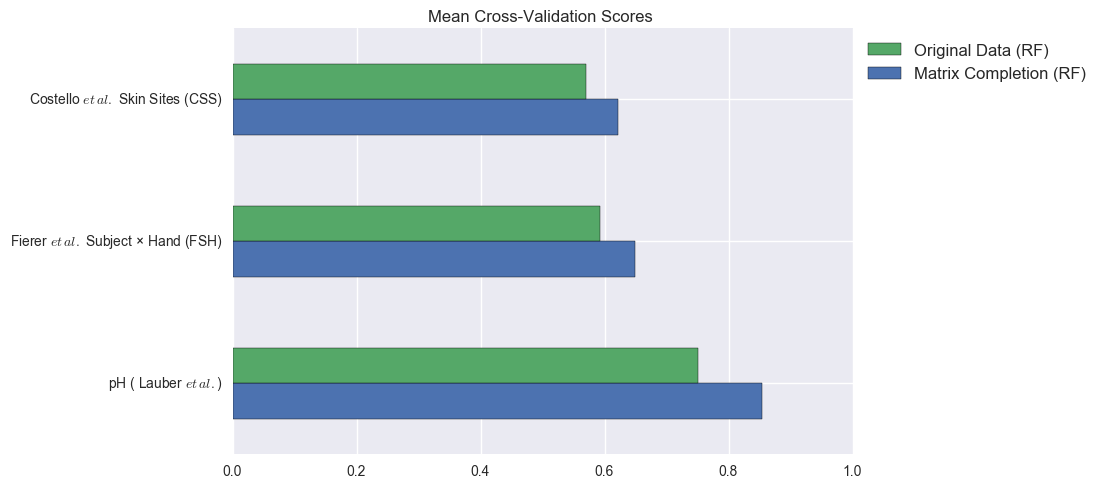

In [65]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
result_both_scores.sort_values(['Matrix Completion (RF)'], ascending = [False], inplace = True)
result_both_scores=result_both_scores.T
#rename a few
result_both_scores=result_both_scores.T
result_both_scores.plot(kind='barh',title='Mean Cross-Validation Scores ',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

# possible correlation between the number of class labels and the percent imporvement after matrix completion

# As we expected the machine leanring improves for all of the tasks

# PCA and PCoA .. Cumulative Explained Variance For Imputed and Origonal Data 

### PCA is one commonly used method for Dimentionality reduction.

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
* Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k < d).
* Construct the projection matrix W from the selected k eigenvectors.
* Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.


### Classically PCA cannot be used to determine clustering of data in 16S because PCA is skewed by outliers and can only deal with small I.I.D. Gaussian nosie

<img src="etc/pca_vs_outlier.png">

### What is PCoA

* It is similar in spirit to PCA but it takes a dissimilarity as input! A dissimilarity matrix shows the distance between every possible pair of objects.

* Is a set of data analysis techniques that display the structure of (complex) distance-like data (a dissimilarity matrix!) in a high dimensional space into a lower dimensional space without too much loss of information.

* The goal of MDS is to faithfully represent these distances with the lowest possible dimensional space.

http://www.sequentix.de/gelquest/help/principal_coordinates_analysis.htm

### Why would you use PCA in 16S analysis 

* Dimensionality Reduction and visualization in 3D

16S rRNA analysis begins by processing raw sequencing reads into a matrix called and OTU table that is high dimensional and by using PCA the data can be visualized in 3 dimensions or less.

* Extract what bacteria are cauing variance between samples directly from PCA visualization 

From PCA graphs you can view which bacteria are contributing most to the changes along an axis in your graph. This means unlike the conventional PCoA, in PCA your axis has meaning!


# Comparing PCA explained variance to state of the art PCoA

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.21958776936576374 and the largest is 24.282150635221882.
  RuntimeWarning
/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See th

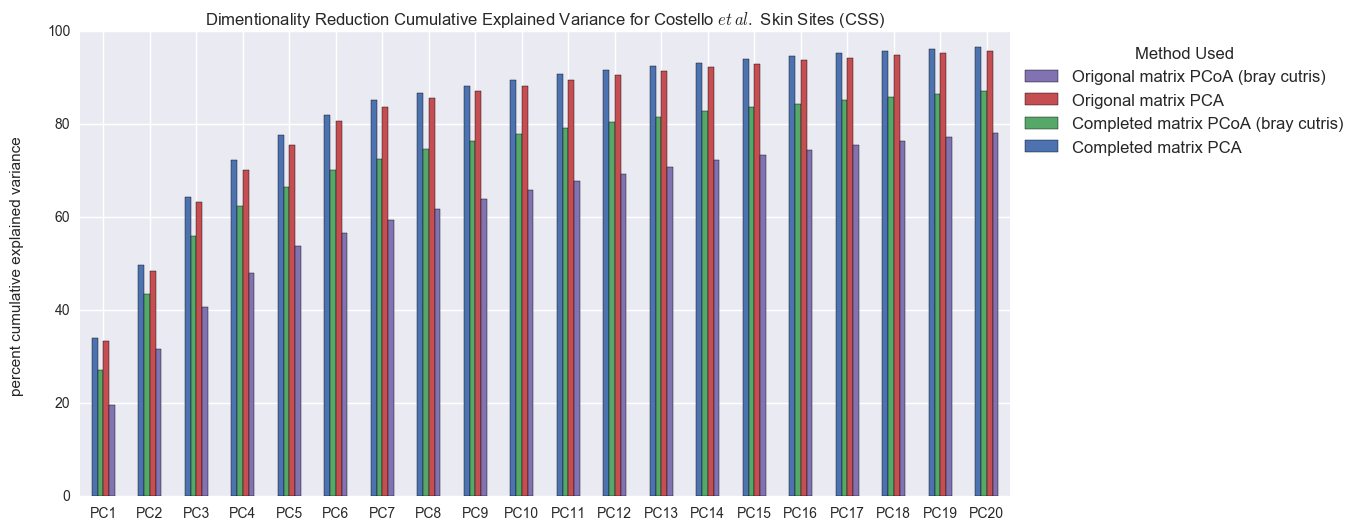

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07213556518192255 and the largest is 7.158837165980151.
  RuntimeWarning
/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the

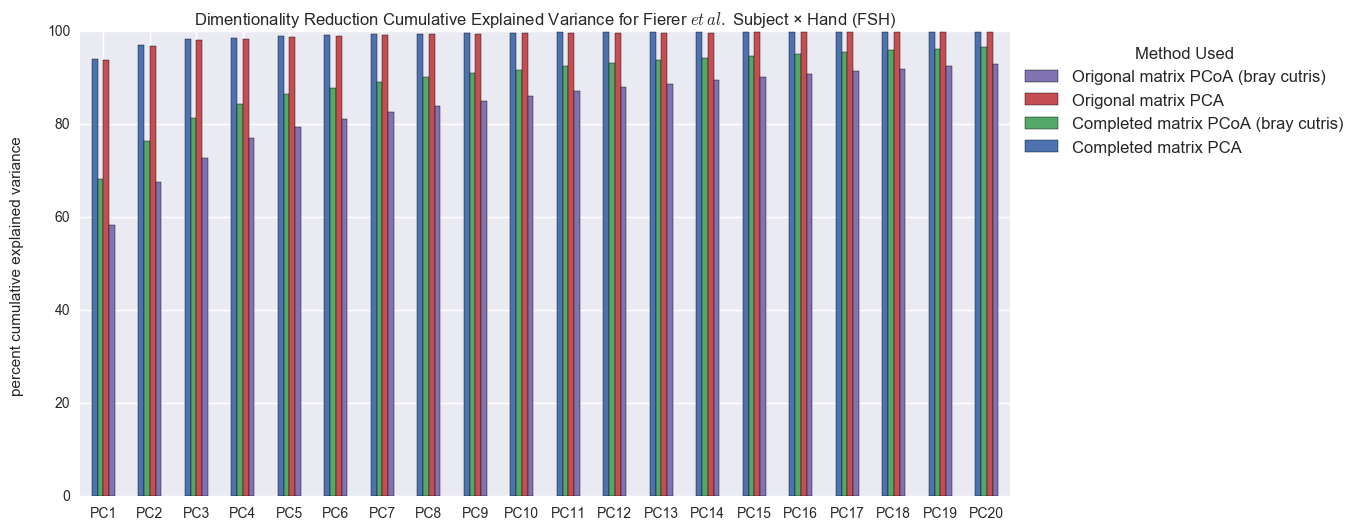

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0014926890541037026 and the largest is 2.12738746796218.
  RuntimeWarning


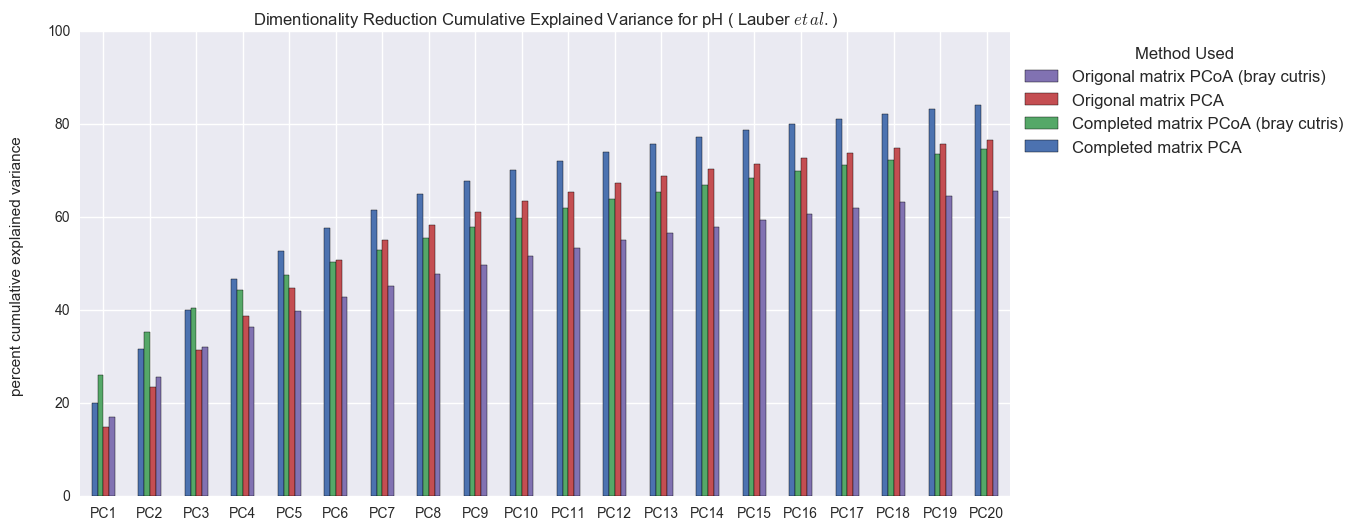

In [3]:
files_to_run={'data/benchmarking/FSH_labels.txt':'data/benchmarking/FSH_otus.txt','data/benchmarking/CSS_labels.txt':'data/benchmarking/CSS_otus.txt','data/benchmarking/88_soils.txt':'data/benchmarking/88_soils.biom'}
chk_j=0
for map_file,in_biom in files_to_run.items():
    txlvl=6 #taxa level to work with
    mapstart_num=0 #starting metadata col
    
    # re-name and set labels for ml    
    if 'CSS' == str(map_file.split('/')[-1].split('_')[0]):
        name_run='Costello $et\,al.$ Skin Sites (CSS)'      
    elif 'FSH' == str(map_file.split('/')[-1].split('_')[0]):        
        name_run='Fierer $et\,al.$ Subject × Hand (FSH)'           
    elif 'soil' in map_file:
        name_run='pH ( Lauber $et \, al.$)'
    
    ########################### metadata classification ##########################################################
    mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
    # re-name and set labels for ml    
    if 'CSS' == str(map_file.split('/')[-1].split('_')[0]):
        mappingdf.columns=['Costello $et\,al.$ Skin Sites (CSS)']
        to_run=['Costello $et\,al.$ Skin Sites (CSS)']        
    elif 'FSH' == str(map_file.split('/')[-1].split('_')[0]):        
        mappingdf.columns=['Fierer $et\,al.$ Subject × Hand (FSH)']
        to_run=['Fierer $et\,al.$ Subject × Hand (FSH)']             
    elif 'soil' in map_file:
        mappingdf = mappingdf[['pH','Annual Season Precipitation']] 
        mappingdf.columns=[['pH ( Lauber $et \, al.$)','Annual Season Precipitation']]
        to_run=['pH ( Lauber $et \, al.$)']
    mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
    if min(mappingdf.shape)<=0:
        sys.exit('Import error from mapping or metadata (less than two samples or features): please check your metadata is tab delimited format')

    ############################# import otu information ###################################################

    try:
        filename=in_biom.split('/')[-1]
    except:
        filename=in_biom

    if filename.split('.')[-1]=="biom":
        #BIOM
        #load table
        total_number_seq_sample=10 # make sure no zero sum samples
        total_number_seq_features=10 # make sure no zero sum otus 
        table = load_table('%s'%in_biom)
        read_filter1 = lambda val, id_, md: sum(val) > total_number_seq_sample
        read_filter2 = lambda val, id_, md: sum(val) > total_number_seq_features
        table.filter(read_filter1, axis='sample')
        table.filter(read_filter2, axis='observation')
        otu, taxonomy = convert_biom_to_pandas(table)
        otu=otu.T
        otu=otu.replace(np.nan,0, regex=True)
        #add taxa names
        taxa_names=list(taxonomy['taxonomy'])
    elif filename.split('.')[-1]=="csv" or filename.split('.')[-1]=="tsv" or filename.split('.')[-1]=="txt":
        #csv
        otu=pd.read_table('%s'%in_biom, index_col=0)
        otu=otu.replace(np.nan,0,regex=True)
        otu=otu.T
        taxa_names=list(otu.index.values)
        if min(otu.shape)<=1:
            sys.exit('Import error less than two samples or features: please check that your data is tab delimited or in biom file format')
    else:
        sys.exit('Import error: please check that your data is one of the following file formats (.csv,.biom,.txt,.tsv)')

    #add unque taxa names for pca/machine leanring (save taxa name for later)
    tax_index=[]
    otus_index=[]
    for q in range(0,len(otu.index.values)):
        otus_index.append("OTU_%s"%str(q))
    otu['new_index']=otus_index
    otu = otu.set_index('new_index')

    #### match and save data #####
    otu, mappingdf = match(otu.T, mappingdf)
    otu=otu.T

    #set taxa names ro level specified by user
    if txlvl==42:
        tax_index=otus_index
    else:
        for t in taxa_names:
            tax_index.append(";".join(t.split(";")[:txlvl]))

    #remove otus with sum to zero after matching files
    otu=otu.loc[(otu!=0).any(1), (otu!=0).any(0)]

    # save data, names and classifiers from data frame
    index = otu.index.values.tolist()
    data = otu.as_matrix()
    ids = otu.columns.values.tolist()
    ids = list(map(str, ids))

    # process taxa names
    tax_index_new=[]
    for cho in index:
        tax_index_new.append(tax_index[int(cho.split("_")[1])])
    tax_index=tax_index_new
    tax_index_new=[]
    #encode pre preoccessing from mapping
    samplenames = mappingdf.index.values.tolist()
    samplenames = map(str, samplenames)

    otum=data.copy() # make copy for imputation
    otum=otum.astype(np.float64)
    otum[otum == 0] = np.nan #make unknown nan
    low_rank_matrix=SoftImpute(max_rank=min(otum.shape),max_iters=500,convergence_threshold=0.0000001,min_value=0,max_value=(np.amax(otum)),verbose=False).complete(otum)
    #intialize to save
    pca_lr=[]
    pcoa_lr=[]
    pca_org=[]
    pcoa_org=[]
    
    pca_model=PCA(n_components=20) #PCA
    X_reduced_var = pca_model.fit_transform(low_rank_matrix.copy()) #transform    
    pccompdf = pd.DataFrame(pca_model.components_,columns=ids,index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20']).T #get wieghts
    pca_lr = np.cumsum(pca_model.explained_variance_ratio_)
    
    #pcoa lr
    ord_results=pcoa(DistanceMatrix(pdist(low_rank_matrix.T,'braycurtis'),ids))
    var_exp=list(ord_results.proportion_explained.values)[:20]
    pcoa_lr=np.cumsum(list(ord_results.proportion_explained.values)[:20])
    
    #pcoa org data 
    ord_results=pcoa(DistanceMatrix(pdist(data.T,'braycurtis'),ids))
    var_exp=list(ord_results.proportion_explained.values)[:20]
    pcoa_org=np.cumsum(list(ord_results.proportion_explained.values)[:20])


    pca_model=PCA(n_components=20) #PCA
    X_reduced_var = pca_model.fit_transform(data.copy()) #transform   
    pccompdf = pd.DataFrame(pca_model.components_,columns=ids,index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20']).T #get wieghts
    var_exp=pca_model.explained_variance_ratio_
    pca_org = np.cumsum(pca_model.explained_variance_ratio_)

    #dataframe to plot
    exp_var_score={'Completed matrix PCA':pca_lr,'Completed matrix PCoA (bray cutris)':pcoa_lr,'Origonal matrix PCA':pca_org,'Origonal matrix PCoA (bray cutris)':pcoa_org}
    exp_var_score_pd = pd.DataFrame(exp_var_score)
    exp_var_score_pd.index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20']
    #plot
    fig, (ax1) = plt.subplots(ncols=1, nrows=1,figsize=(12,6))
    exp_var_score_pd=exp_var_score_pd*100
    exp_var_score_pd.plot(kind='bar',title='Dimentionality Reduction Cumulative Explained Variance for %s'%(name_run),ylim=(0,100),rot=0,ax=ax1)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0),title='Method Used')
    ax1.set_ylabel('percent cumulative explained variance \n')
    plt.show()

# Case Study 1

# 88 Soils Case Study

In [42]:
# import data 
map_file='data/benchmarking/88_soils.txt' #import metadata
in_biom='data/benchmarking/88_soils.biom' #import biom file
txlvl=6
#taxa level to work with
mapstart_num=0 #starting metadata col


########################### metadata classification ##########################################################

print('\n Importing Metadata for analysis\n')
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
if min(mappingdf.shape)<=0:
    sys.exit('Import error from mapping or metadata (less than two samples or features): please check your metadata is tab delimited format')
print('\n Done')

mappingdf['pH_rounded'] = [(round(n, 0)) for n in list(mappingdf['pH'])]

############################# import otu information ###################################################

print('\n Importing .biom table for analysis \n')

try:
    filename=in_biom.split('/')[-1]
except:
    filename=in_biom

if filename.split('.')[-1]=="biom":
    #BIOM
    #load table
    total_number_seq_sample=100
    total_number_seq_features=100
    table = load_table('%s'%in_biom)
    read_filter1 = lambda val, id_, md: sum(val) > total_number_seq_sample
    read_filter2 = lambda val, id_, md: sum(val) > total_number_seq_features
    table.filter(read_filter1, axis='sample')
    table.filter(read_filter2, axis='observation')
    otu, taxonomy = convert_biom_to_pandas(table)
    otu=otu.T
    otu=otu.replace(np.nan,0, regex=True)
    #add taxa names
    taxa_names=list(taxonomy['taxonomy'])
elif filename.split('.')[-1]=="csv" or filename.split('.')[-1]=="tsv" or filename.split('.')[-1]=="txt":
    #csv
    otu=pd.read_table('%s'%in_biom, index_col=0)
    taxa_names=list(otu.index.values)
    otu=otu.replace(np.nan,0, regex=True)
    if min(otu.shape)<=1:
        sys.exit('Import error less than two samples or features: please check that your data is tab delimited or in biom file format')
else:
    sys.exit('Import error: please check that your data is one of the following file formats (.csv,.biom,.txt,.tsv)')

#add unque taxa names for pca/machine leanring (save taxa name for later)
tax_index=[]
otus_index=[]
for q in range(0,len(otu.index.values)):
    otus_index.append("OTU_%s"%str(q))
otu['new_index']=otus_index
otu = otu.set_index('new_index')

#### match and save data #####
otu, mappingdf = match(otu.T, mappingdf)
otu=otu.T

#set taxa names ro level specified by user
if txlvl==42:
    tax_index=otus_index
else:
    for t in taxa_names:
        tax_index.append(";".join(t.split(";")[:txlvl]))

#remove otus with sum to zero after matching files
otu=otu.loc[(otu.sum(axis=1) != 0)]

# save data, names and classifiers from data frame
index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = list(map(str, ids))

# process taxa names
tax_index_new=[]
for cho in index:
    tax_index_new.append(tax_index[int(cho.split("_")[1])])
tax_index=tax_index_new
tax_index_new=[]
#encode pre preoccessing from mapping
samplenames = mappingdf.index.values.tolist()
samplenames = map(str, samplenames)
encoded_mapping={} #save coded and uncoded as dict
encoded_mappingdf=mappingdf.copy() # encoded dataframe
le = preprocessing.LabelEncoder() # encoder prepreocessing
classifiers_meta=mappingdf.columns.values.tolist() # classifier names
for metatmp in classifiers_meta[mapstart_num:]: # run each classifier
    le.fit(list(set(list(mappingdf[metatmp]))))
    encoded = le.transform(list(mappingdf[metatmp]))
    not_encoded = le.inverse_transform(encoded)
    encoded_mapping[metatmp]=[encoded,not_encoded]
    encoded_mappingdf[metatmp]=encoded #encoded dataframe

#size
print("  Number of samples %i"%(int((data.shape[1]))))
print("  Number of OTUs %i"%(int((data.shape[0]))))
print("\n Done")


 Importing Metadata for analysis


 Done

 Importing .biom table for analysis 

  Number of samples 88
  Number of OTUs 116

 Done


In [44]:
# complete the matrix 
otum=data.copy() # make copy for imputation
otum=otum.astype(np.float64)
otum[otum == 0] = np.nan #make unknown nan
low_rank_matrix=SoftImpute(max_rank=min(otum.shape),max_iters=100,convergence_threshold=0.00001,min_value=0,max_value=(np.amax(otum)),verbose=False).complete(otum)

# Machine Learning

In [18]:
sv={} # save scores for each classifier
rng = np.random.RandomState(42)
to_run=list(mappingdf.columns[:-1])
mapstart_num=0
split_tmp=0
for reduced_this in to_run:

    #remove all unknown samples for metadata column
    low_rank_matrix_matched,mappingdf_matched = match(pd.DataFrame(low_rank_matrix,index,ids).T,mappingdf) #filter data for unknowns
    mappingdf_matched_encoded,mappingdf_matched = match(encoded_mappingdf,mappingdf_matched)
    low_rank_matrix_matched=low_rank_matrix_matched.as_matrix()

    # run ten times
    crssval=[]
    q=0
    while q<=10:

        # split data
        X_train, X_test, y_train_all, y_test_all = train_test_split(low_rank_matrix.T.copy(),np.array(mappingdf_matched_encoded.as_matrix()),test_size=0.2,random_state=rng)
        #start machine learning
        metatmp=reduced_this
        check_tmp=0
        for check_occurance in list(set(encoded_mapping[metatmp][1])):
            if all(isinstance(item, str) for item in encoded_mapping[metatmp][1]) and check_tmp==0:
                if list(encoded_mapping[metatmp][1]).count(check_occurance) <=1:
                    check_tmp+=1
                    print("    Warning: Skipping Catagory: %s contains labels that occurs only once, will cause spurious results."%(str(metatmp)))
                    continue

        y_train=y_train_all.T[split_tmp]
        y_test=y_test_all.T[split_tmp]
        if len(set(encoded_mapping[metatmp][0]))<=1: # can not learn classifiers with one label
            print("    Warning: Skipping Catagory: %s,  Catagory must have more than one label!"%str(metatmp))
            continue

        elif len(set(encoded_mapping[metatmp][0]))>2 and all(isinstance(item, str) for item in encoded_mapping[metatmp][1]): # if not quantity and class is not boolian
            clfm = RandomForestClassifier(random_state=rng) 
            clfm.fit(X_train, y_train)
            crssval.append(clfm.score(X_test, y_test))
        else: # if continous 
            clfr = RandomForestRegressor(random_state=rng) # grid search for optimized perams
            clfr.fit(X_train, y_train)
            crssval.append(clfr.score(X_test, y_test))
        q+=1

    #next column
    split_tmp+=1     
    #save mean score
    sv[metatmp] = np.mean(crssval)

#Convert dict to dataframe and choose colors
scores=pd.DataFrame(list(sv.items()))
scores=scores.set_index(scores[0])
scores=scores.drop([0], 1)
scores.columns = ['Scores']
scores.sort_values(['Scores'], ascending = [False], inplace = True)

In [19]:
#add info to labels
new_names=[]
for get_s in list(scores.index.values):
    new_names.append(get_s+' (n='+str(len(mappingdf[~mappingdf[get_s].isin(['Unknown','adult'])][get_s]))+')'+' (labels='+str(len(list(set(mappingdf[~mappingdf[get_s].isin(['Unknown','adult'])][get_s]))))+')') 
scores.index=new_names

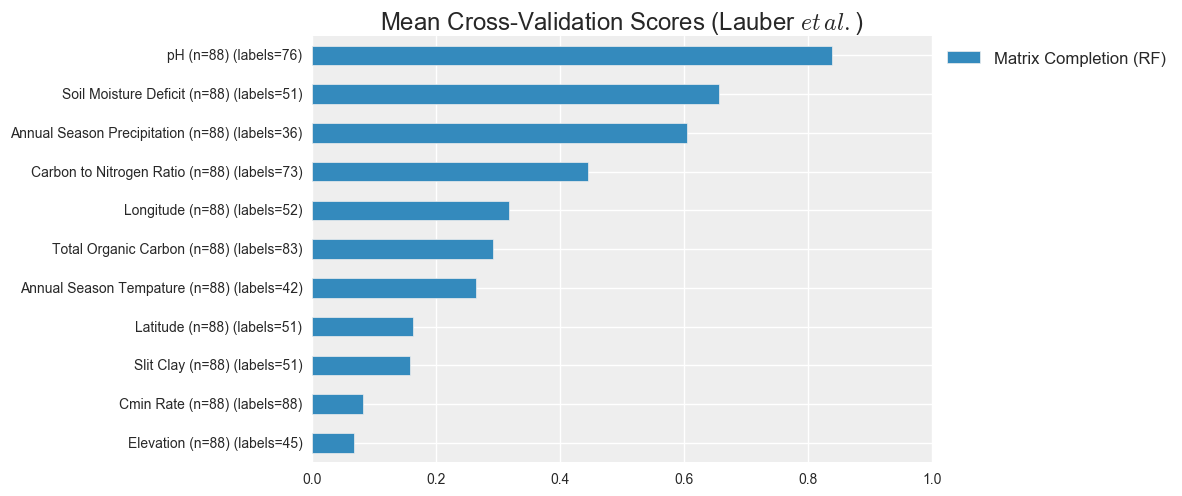

In [20]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
scores.columns=['Matrix Completion (RF)']
scores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
scores=scores.T
#rename a few
scores=scores.T
scores.plot(kind='barh',title='Mean Cross-Validation Scores (Lauber $et \, al.$)',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

# Outliers detection 

### Outliers are detected through Local Outlier Factor analysis 

### Example of why PCA on 16S data is a bad idea , outliers cause a large skew in the data

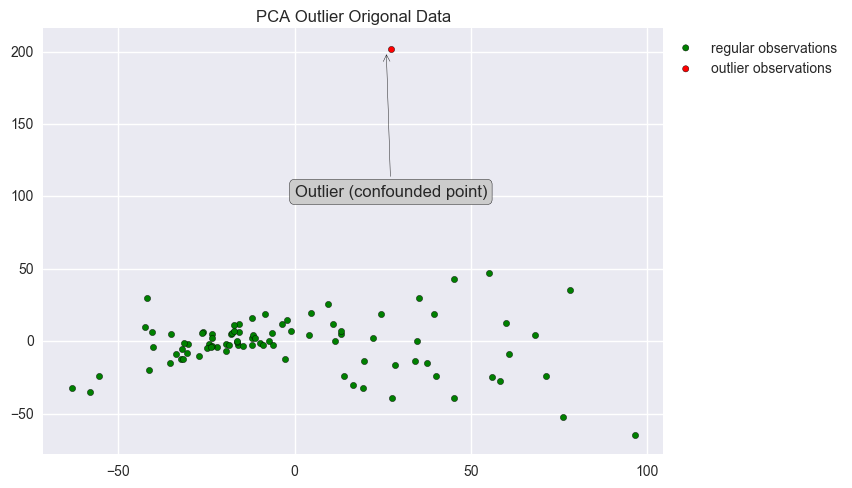

In [34]:
# fit the model for PCA on org data 
clf = LocalOutlierFactor(n_neighbors=20,metric='euclidean',contamination=0.01)
data_plot=clr(data+1)
lcf_f = clf.fit_predict(data.T)
pca_model=PCA(n_components=2) #PCA
X1=pca_model.fit_transform(data.T.copy()) #transform
q=0
check1=0
check2=0
outliers=list(lcf_f)
X1=X1.T
for v in list(outliers):
    if v==1:
        if check1==0:
            X_normal=X1.T[q]
            check1+=1
        else:
            X_normal=np.c_[X_normal,X1.T[q]]            
    elif v==-1:
        if check2==0:
            X_outlier=X1.T[q]
            check2+=1
        else:
            X_outlier=np.c_[X_outlier,X1.T[q]]        
    else:
        print("skipping")
    q+=1
    
plt.title("PCA Outlier Origonal Data")
b2=plt.scatter(X_normal[0], X_normal[1], c='green')
c=plt.scatter(X_outlier[0], X_outlier[1], c='red')
plt.axis('tight')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("Outlier (confounded point)", xy=(26, 200),xycoords="data", textcoords="data",xytext=(0, 100), bbox=bbox_args, arrowprops=arrow_args)
plt.legend([b2, c],["regular observations", "outlier observations"],bbox_to_anchor=(1.3, 1.0))
plt.show()

### Example of how we can re-create PCoA plots through matrix imputation 

# PCoA on orgional data 

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/sklearn/neighbors/lof.py:180: UserWarning: n_neighbors (89) is greater than the total number of samples (88). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.101470853958465 and the largest is 7.1830834761287825.
  RuntimeWarning


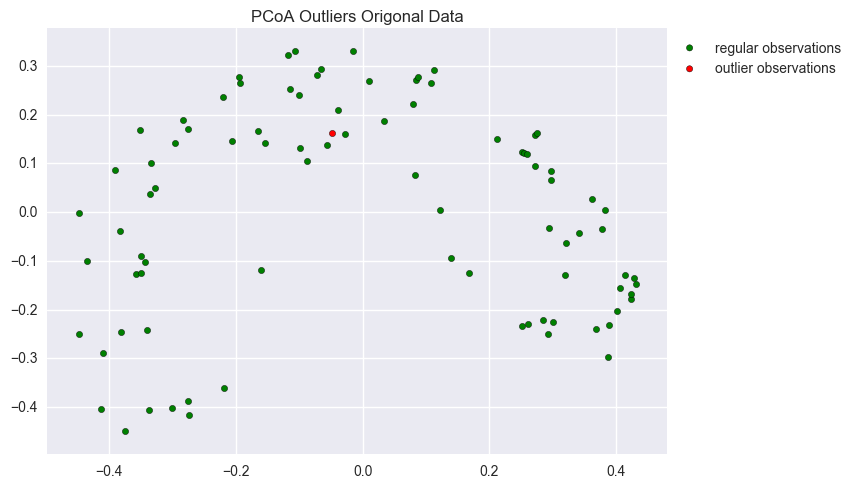

In [17]:
# fit the model for PCA on org data
clf = LocalOutlierFactor(n_neighbors=89,metric='braycurtis',contamination=0.01)
lcf_f = clf.fit_predict(data.T)
#PCoA
X1=pcoa(DistanceMatrix(pdist(data.T,'braycurtis'),ids)).samples[['PC1','PC2']].as_matrix()
q=0
check1=0
check2=0
outliers=list(lcf_f)
X1=X1.T
for v in list(outliers):
    if v==1:
        if check1==0:
            X_normal=X1.T[q]
            check1+=1
        else:
            X_normal=np.c_[X_normal,X1.T[q]]            
    elif v==-1:
        if check2==0:
            X_outlier=X1.T[q]
            check2+=1
        else:
            X_outlier=np.c_[X_outlier,X1.T[q]]        
    else:
        print("skipping")
    q+=1

plt.figure(1)
plt.title("PCoA Outliers Origonal Data")
b2=plt.scatter(X_normal[0], X_normal[1], c='green')
c=plt.scatter(X_outlier[0], X_outlier[1], c='red')
plt.axis('tight')
plt.legend([b2, c],["regular observations", "outlier observations"],bbox_to_anchor=(1.3, 1.0))
plt.show()

# PCA on completed matrix 

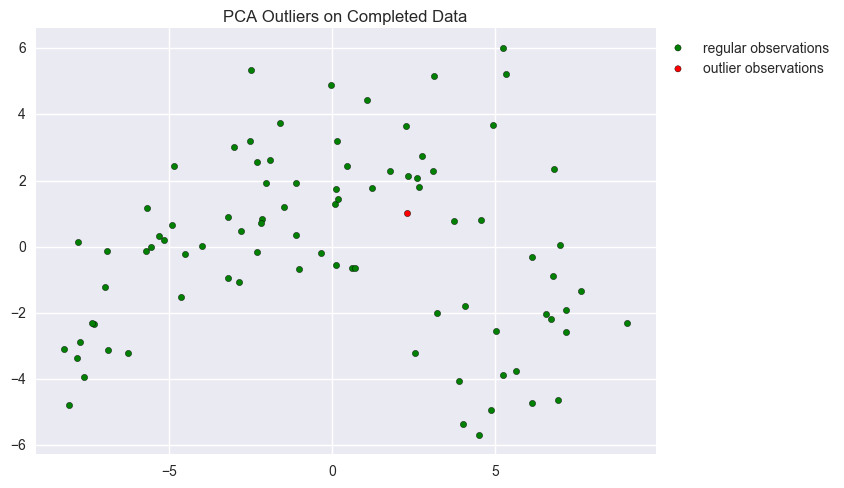

In [45]:
# fit the model on PCA for completed data (clr transform on completed data)
clf = LocalOutlierFactor(n_neighbors=20,metric='euclidean',contamination=0.01)
low_rank_matrix_plot=clr(low_rank_matrix+1)
lcf_f = clf.fit_predict(data.T)
#low rank
pca_model=PCA(n_components=2) #PCA
X1 = pca_model.fit_transform(low_rank_matrix_plot.T.copy()) #transform

q=0
check1=0
check2=0
outliers=list(lcf_f)
X1=X1.T
for v in list(outliers):
    if v==1:
        if check1==0:
            X_normal=X1.T[q]
            check1+=1
        else:
            X_normal=np.c_[X_normal,X1.T[q]]            
    elif v==-1:
        if check2==0:
            X_outlier=X1.T[q]
            check2+=1
        else:
            X_outlier=np.c_[X_outlier,X1.T[q]]        
    else:
        print("skipping")
    q+=1
    
plt.title("PCA Outliers on Completed Data")
b2=plt.scatter(X_normal[0], X_normal[1], c='green')
c=plt.scatter(X_outlier[0], X_outlier[1], c='red')
plt.axis('tight')
plt.legend([b2, c],["regular observations", "outlier observations"],bbox_to_anchor=(1.3, 1.0))
plt.show()

### As you can see we have removed the gross outliers and the outliers that are left are very close to the rest of the data. We now want to justify why we went to all the trouble of doing this and not just running PCoA

# Motivation to using PCA Extracting biological knowledge through PCA and Matrix Completion

# Increased Explained Variance Between Methods

# Example: Learning Bacteria that Cause Variance Along Axis for pH

#### Recovering information about features from PCA eigenvectors  


### Suppose we would like to see how the bacteria chnage along this first axis of pH since our machine leanring identified that as the best catagory from the metadata.

### If the gradient change is along that axis we can then say what bacteria chnages the most along that axis.

### The priniple components are a linear combination of origonal features in N dimentional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are wieghts and $X_{N}$ is the origonal variables

#### Therefore the coefficients are the transfrom of an idenity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

# Example of axis to use

## First Axis (PC-1) Explained Bacterial Variance 

In [23]:
# View bacteria causing variance on the first axis
bact_to_show=25 # number of bacteria to extract
niche_plot='pH' # any column from mapping
Pc_plot="PC-1" # can be PC-2
imputed_in=low_rank_matrix_plot.copy() # imputed data to use
cont=True # default true, false if not continous data
# Extract information from imputed PCA axis  
out_niche_linkeddf,observed_table_sfi,index_mean,index_std,highest_var_bact,pccompdf  = PCA_niche.niche_visual(otu,imputed_in,tax_index,bact_to_show,niche_plot,Pc_plot,mappingdf)
#PCA
observed_table_sfi, mapping = match(observed_table_sfi.T, mappingdf)
pca_model=PCA(n_components=2)
X2=observed_table_sfi.as_matrix()
X_reduced2 = pca_model.fit_transform(X2)

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/pandas/indexes/multi.py:610: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)


# Visulaize the figure 

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


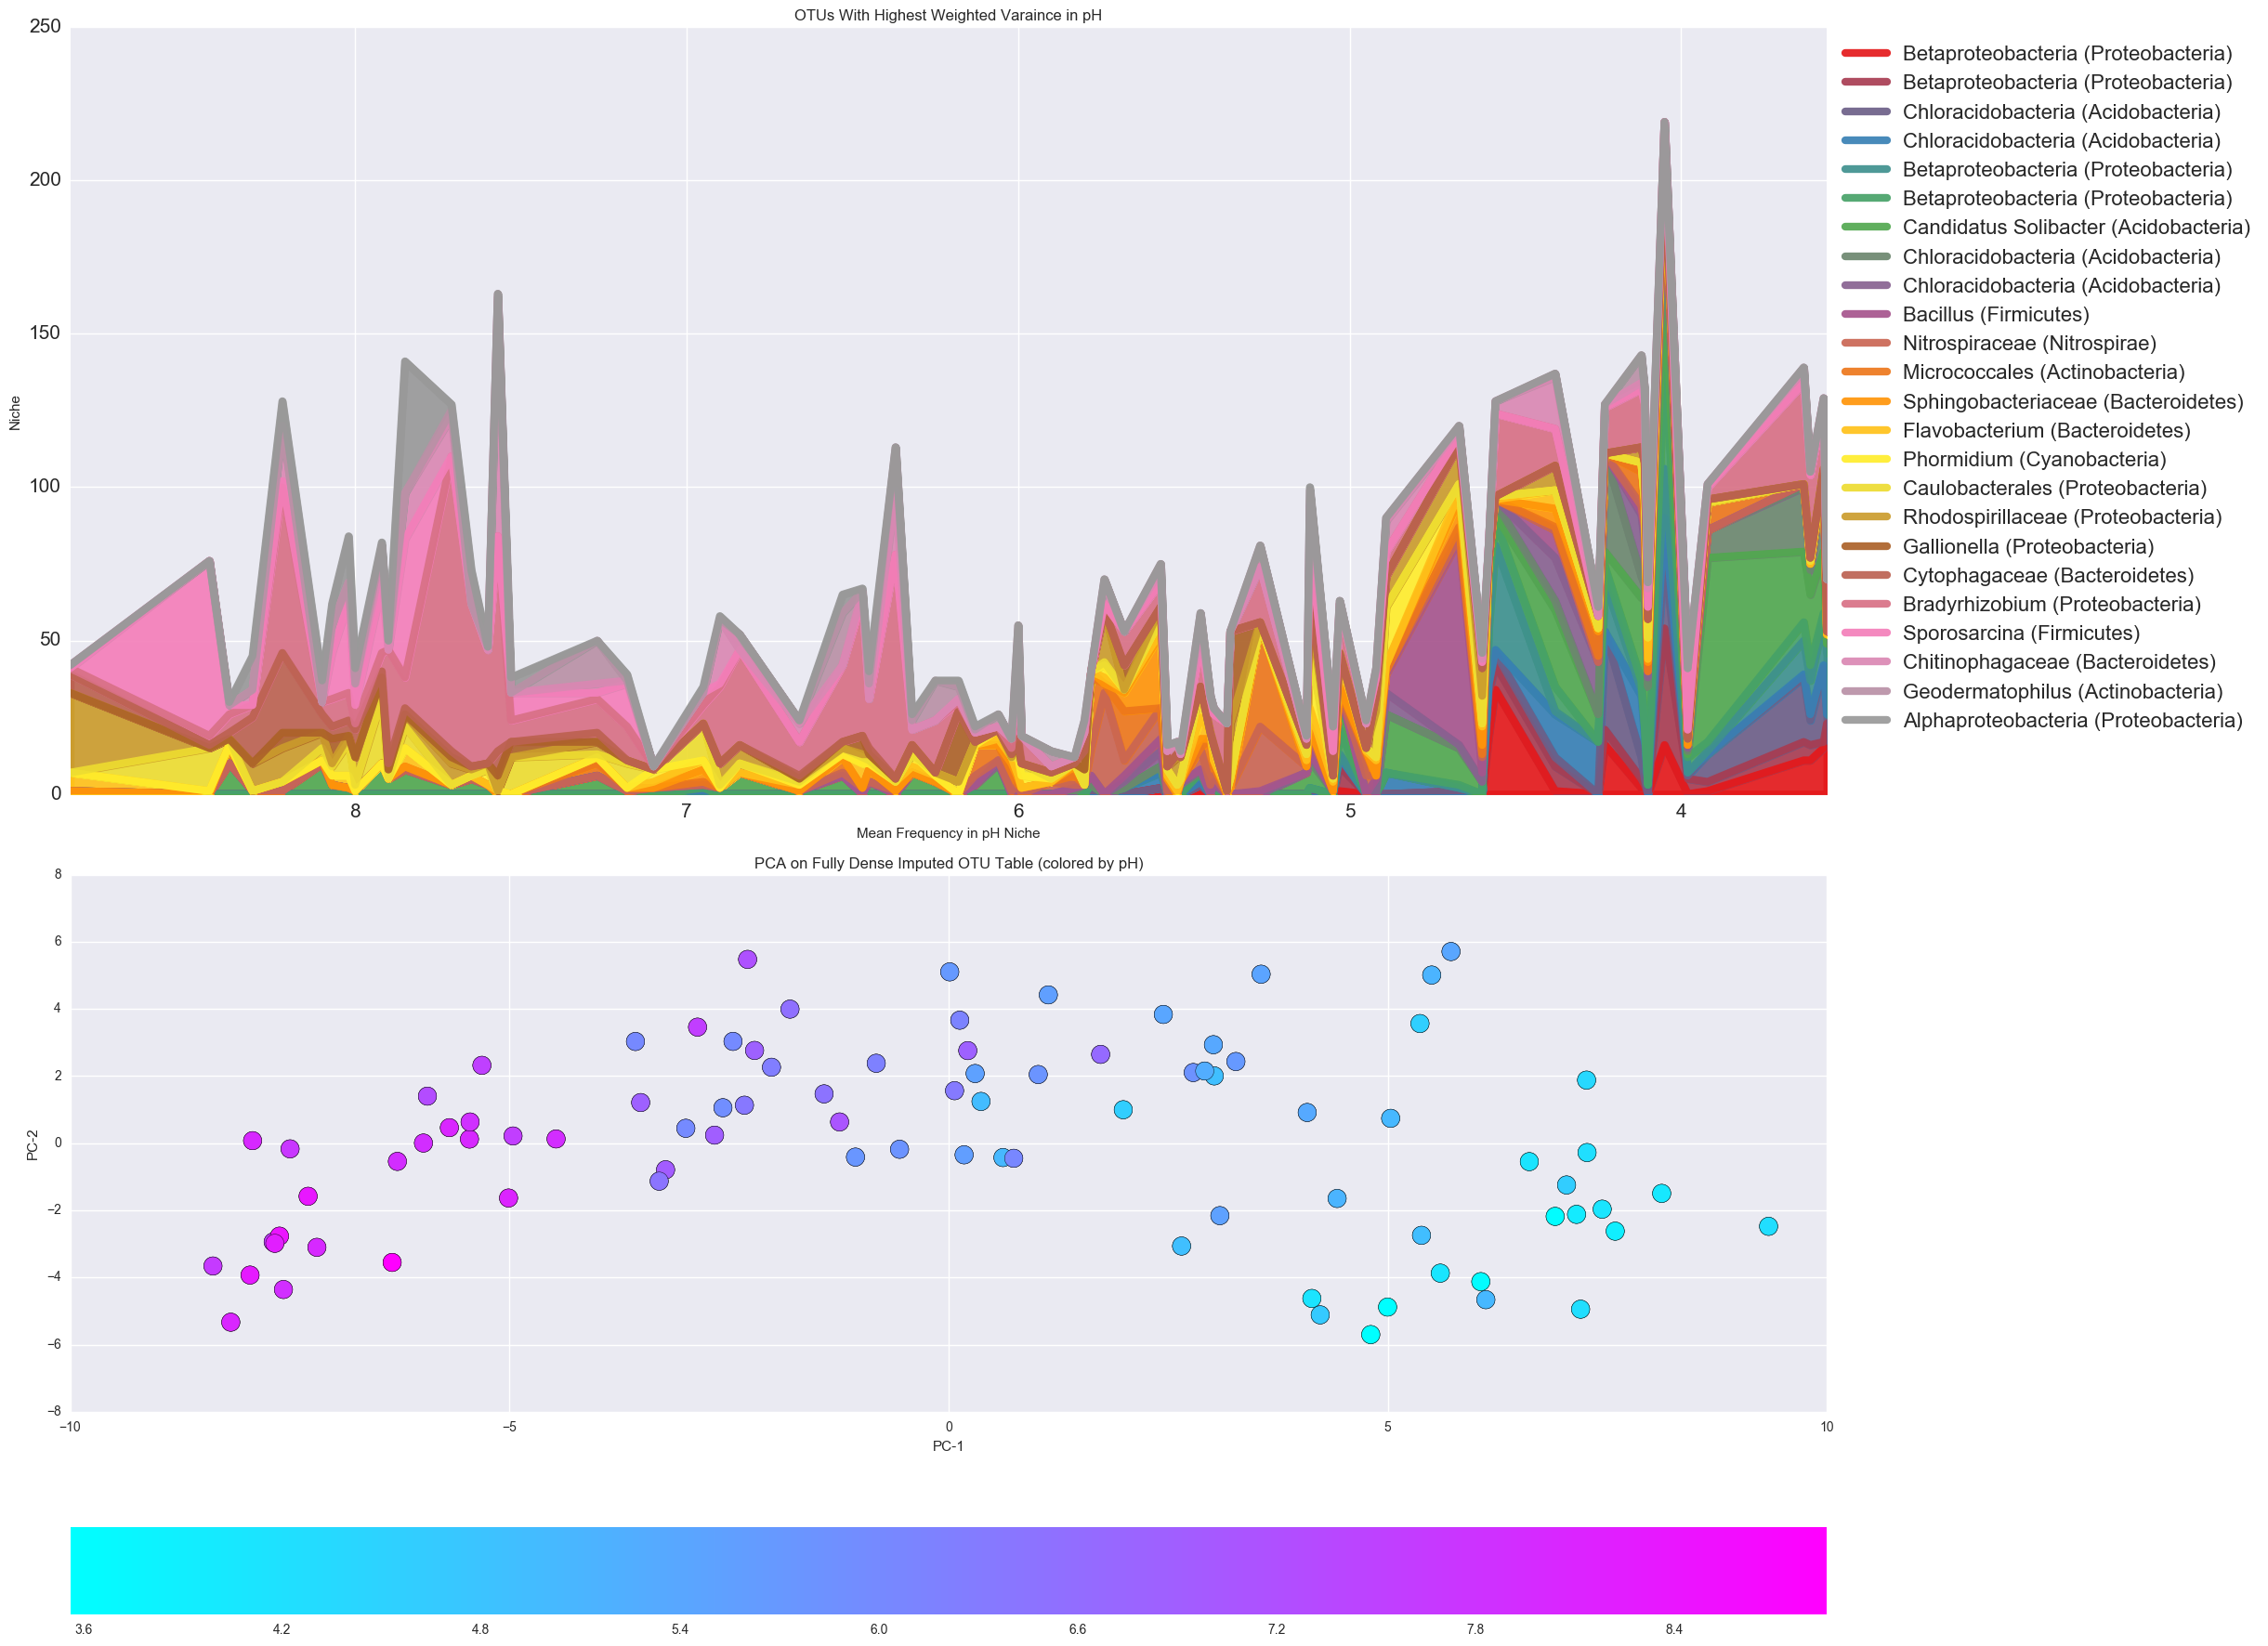

In [141]:
index_mean_new=[]
index_std_new=[]
new_taxa=[]
#lowest taxaclassification + (phylum)
for nm in out_niche_linkeddf.index.values.tolist():
    #find lowest taxa level 
    q=0
    while q<(len(nm.split(';'))-1):
        lw=nm.split(';')[q]
        q+=1
        if len(nm.split(';')[q])==3 or '1'in nm.split(';')[q] or '2' in nm.split(';')[q]:
            break
    if '[' in lw.split('__')[1]:
        lw=lw.split('__')[1]
        lw=lw[1:-1]
    else:
        lw=lw.split('__')[1]  
    
    if 'std' in nm:
        index_std_new.append(lw+' ('+nm.split(';')[0].split('__')[1]+')'+'std')
        new_taxa.append(lw+' ('+nm.split(';')[0].split('__')[1]+')'+'std')
    else:
        index_mean_new.append(lw+' ('+nm.split(';')[0].split('__')[1]+')')
        new_taxa.append(lw+' ('+nm.split(';')[0].split('__')[1]+')')    
out_niche_linkeddf.index=new_taxa
out_niche_linkeddf.columns=list(out_niche_linkeddf.columns)[::-1]
#plot
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(20, 18),sharey=False)
#out_niche_linkeddf.T[index_mean].plot(kind='bar',width=.78, yerr=out_niche_linkeddf.T[index_std].values.T, alpha = 0.92,error_kw=dict(elinewidth=1,capsize=2,barsabove=True,ecolor='k',ms=1, mew=1),rot=0,colormap="Set1",sharey=True,fontsize=15,ax=ax1)
out_niche_linkeddf.T[index_mean_new[:-5]].plot(kind='area',lw=6, alpha = 0.92,rot=0,colormap="Set1",sharey=True,fontsize=15,ax=ax1)
ax1.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
Y=encoded_mapping[niche_plot][0].tolist()
ax2.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=list(list(mappingdf[niche_plot])),cmap=plt.cm.cool,s=200)
p=ax2.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=list(list(mappingdf[niche_plot])),cmap=plt.cm.cool,s=200)
fig.colorbar(p,orientation='horizontal')
# Set common labels
ax1.set_xlabel(('Mean Frequency in %s Niche'%niche_plot))
ax1.set_ylabel('Niche')
ax2.set_xlabel('PC-1')
ax2.set_ylabel('PC-2')
ax2.set_xlim([-10, 10])
ax1.set_title(('OTUs With Highest Weighted Varaince in %s'%niche_plot))
ax2.set_title(('PCA on Fully Dense Imputed OTU Table (colored by %s)'%niche_plot))
fig.set_tight_layout(True)
plt.show()

# Example of axis not to use

## Second Axis (PC-2) Explained Bacterial Variance 

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/pandas/indexes/multi.py:610: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)
/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


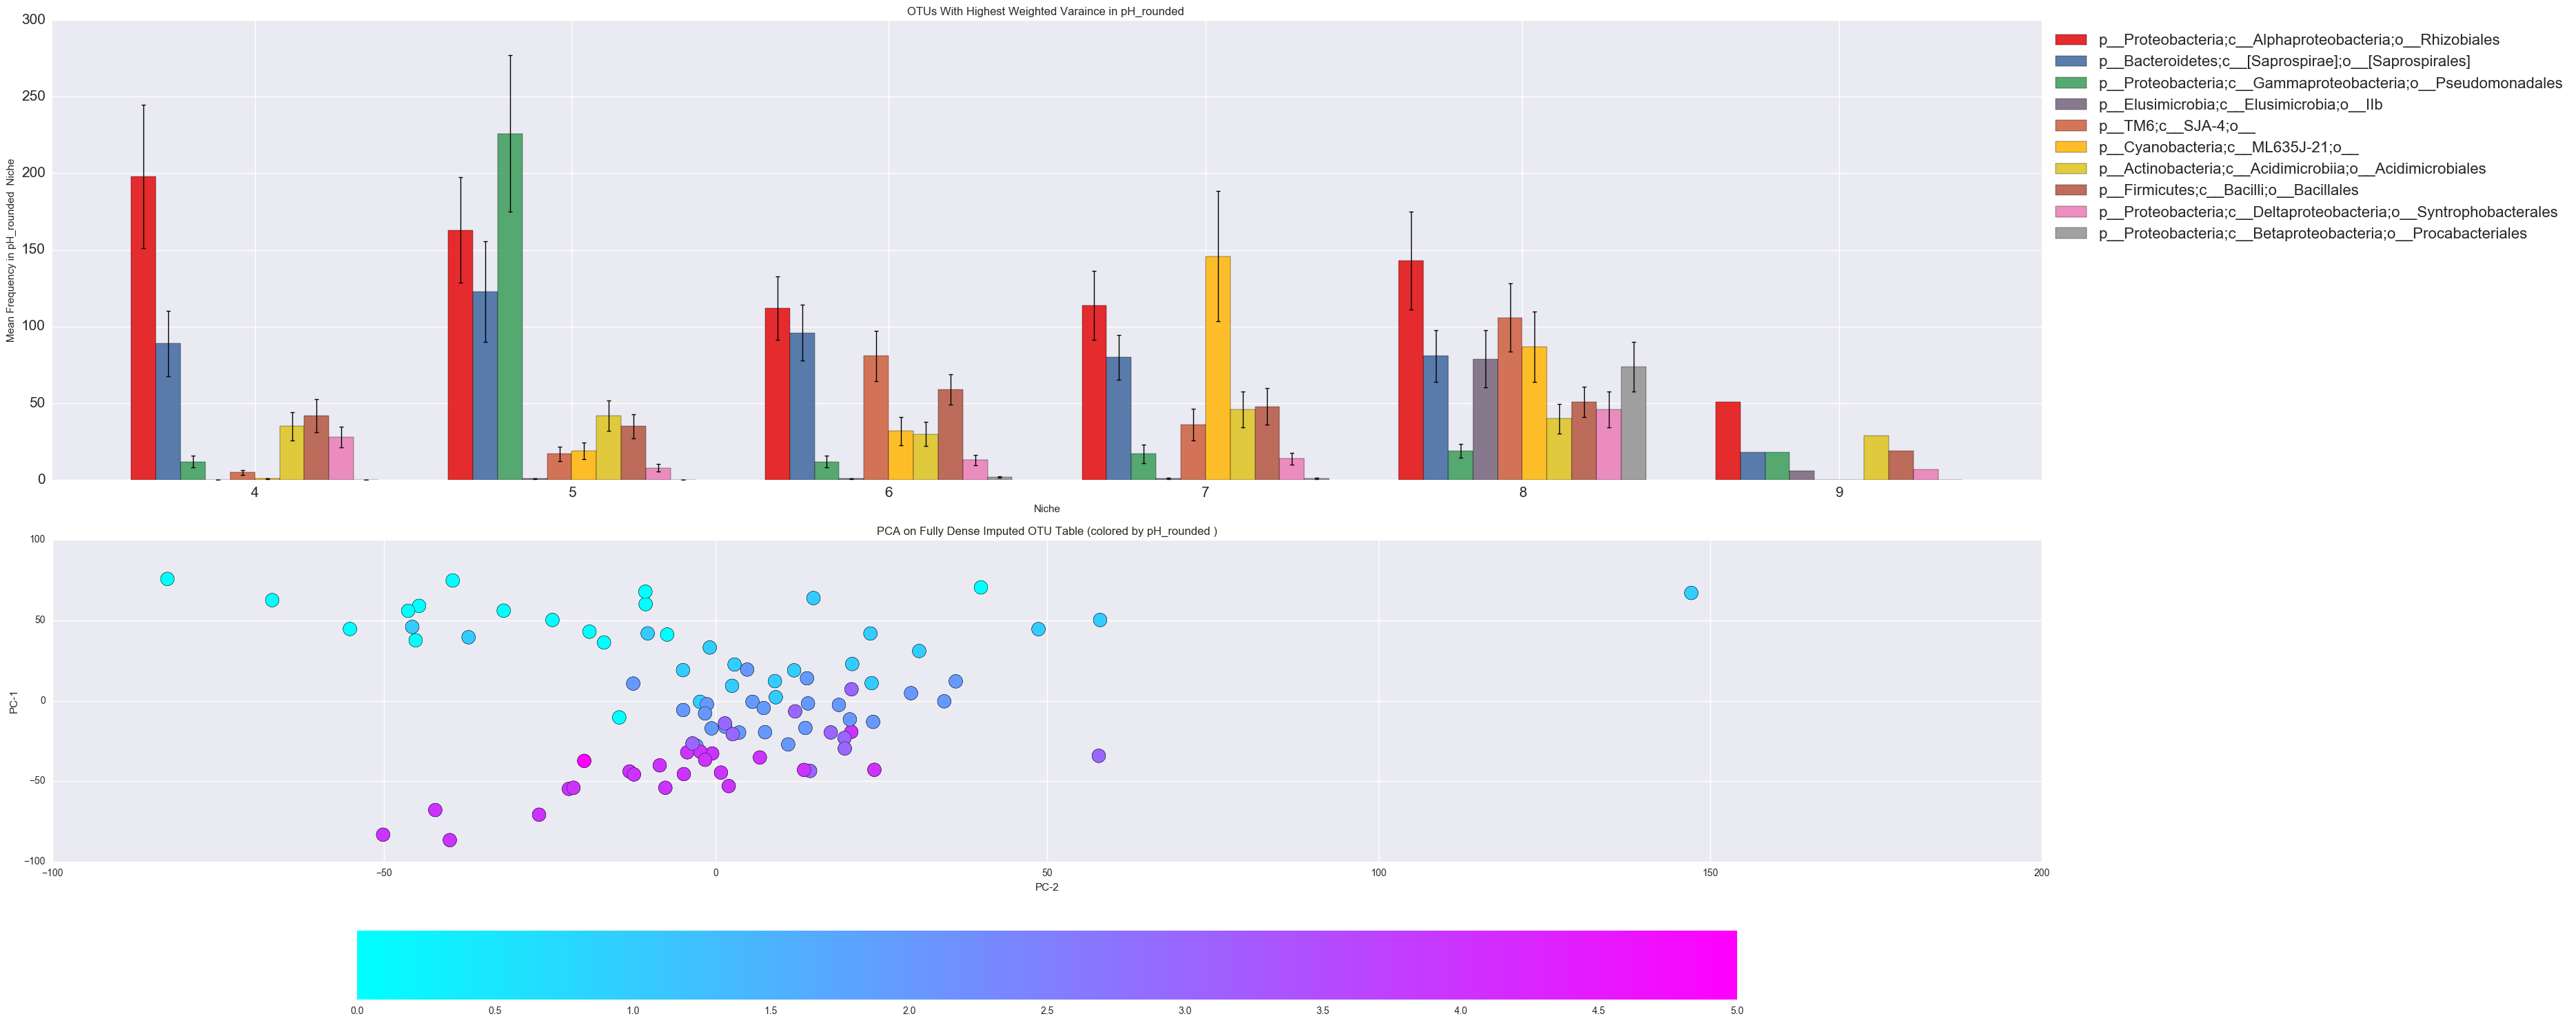

In [8]:
# View bacteria causing variance on the first axis
bact_to_show=10 # number of bacteria to extract
niche_plot='pH_rounded ' # any column from mapping
Pc_plot="PC-2" # can be PC-2
imputed_in=low_rank_matrix_plot.copy() # imputed data to use
cont=True # default true, false if not continous data
# Extract information from imputed PCA axis  
out_niche_linkeddf,observed_table_sfi,index_mean,index_std,highest_var_bact,pccompdf  = PCA_niche.niche_visual(otu,imputed_in,tax_index,bact_to_show,niche_plot,Pc_plot,mappingdf,weight)
# Visualize the data
plt = PCA_niche.plot_niche(out_niche_linkeddf,observed_table_sfi,mappingdf,encoded_mapping,niche_plot,Pc_plot,index_mean,index_std,le,cont,weight)
plt.show()

## The Bacteria with the highest variance between pH clusters by multivariate weights make sense because they belong to the families Bradyrhizobiaceae, Sinobacteraceae and Acidobacteriaceae. All of which have members that are described to grow at pH as low as 3 (B. elkanii (Jordan, 1982) and A. capsulatum (Hrash and Coates, 2011)), and pH 5 (S. flavus (Zhou et al., 2008)).

# This not only matches the papers conclustions where this data came from 

http://aem.asm.org/content/75/15/5111.full

# It also makes Biological sense



# Case Study 2

# Sponge Case Study

In [363]:
# import data 
map_file='data/benchmarking/Thomas_sponge_communities.txt' #import metadata
in_biom='data/benchmarking/Thomas_sponge_communities.biom' #import biom file
txlvl=6 #taxa level to work with
mapstart_num=0 #starting metadata col


########################### metadata classification ##########################################################

print('\n Importing Metadata for analysis\n')
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
if min(mappingdf.shape)<=0:
    sys.exit('Import error from mapping or metadata (less than two samples or features): please check your metadata is tab delimited format')
#remove single class columns
for rm_ch in mappingdf.columns:
    if len(set(mappingdf[rm_ch]))==1:
           mappingdf.drop(rm_ch, axis=1, inplace=True)
print('\n Done')

############################# import otu information ###################################################

print('\n Importing .biom table for analysis \n')

try:
    filename=in_biom.split('/')[-1]
except:
    filename=in_biom

if filename.split('.')[-1]=="biom":
    #BIOM
    #load table
    total_number_seq_sample=0 
    total_number_seq_features=0 
    table = load_table('%s'%in_biom)
    read_filter1 = lambda val, id_, md: sum(val) > total_number_seq_sample
    read_filter2 = lambda val, id_, md: sum(val) > total_number_seq_features
    table.filter(read_filter1, axis='sample')
    table.filter(read_filter2, axis='observation')
    otu, taxonomy = convert_biom_to_pandas(table)
    otu=otu.T
    otu=otu.replace(np.nan,0, regex=True)
    #add taxa names
    taxa_names=list(taxonomy['taxonomy'])
elif filename.split('.')[-1]=="csv" or filename.split('.')[-1]=="tsv" or filename.split('.')[-1]=="txt":
    #csv
    otu=pd.read_table('%s'%in_biom, index_col=0)
    taxa_names=list(otu.index.values)
    otu=otu.replace(np.nan,0, regex=True)
    if min(otu.shape)<=1:
        sys.exit('Import error less than two samples or features: please check that your data is tab delimited or in biom file format')
else:
    sys.exit('Import error: please check that your data is one of the following file formats (.csv,.biom,.txt,.tsv)')

#add unque taxa names for pca/machine leanring (save taxa name for later)
tax_index=[]
otus_index=[]
for q in range(0,len(otu.index.values)):
    otus_index.append("OTU_%s"%str(q))
otu['new_index']=otus_index
otu = otu.set_index('new_index')

#### match and save data #####
otu, mappingdf = match(otu.T, mappingdf)
otu=otu.T

#set taxa names ro level specified by user
if txlvl==42:
    tax_index=otus_index
else:
    for t in taxa_names:
        tax_index.append(";".join(t.split(";")[:txlvl]))

#remove otus with sum to zero after matching files
otu=otu.loc[(otu.sum(axis=1) != 0)]

# save data, names and classifiers from data frame
index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = list(map(str, ids))

# process taxa names
tax_index_new=[]
for cho in index:
    tax_index_new.append(tax_index[int(cho.split("_")[1])])
tax_index=tax_index_new
tax_index_new=[]
#encode pre preoccessing from mapping
samplenames = mappingdf.index.values.tolist()
samplenames = map(str, samplenames)
encoded_mapping={} #save coded and uncoded as dict
encoded_mappingdf=mappingdf.copy() # encoded dataframe
le = preprocessing.LabelEncoder() # encoder prepreocessing
classifiers_meta=mappingdf.columns.values.tolist() # classifier names
for metatmp in classifiers_meta[mapstart_num:]: # run each classifier
    le.fit(list(set(list(mappingdf[metatmp]))))
    encoded = le.transform(list(mappingdf[metatmp]))
    not_encoded = le.inverse_transform(encoded)
    encoded_mapping[metatmp]=[encoded,not_encoded]
    encoded_mappingdf[metatmp]=encoded #encoded dataframe

#size
print("  Number of samples %i"%(int((data.shape[1]))))
print("  Number of OTUs %i"%(int((data.shape[0]))))
print("\n Done")


 Importing Metadata for analysis


 Done

 Importing .biom table for analysis 

  Number of samples 1403
  Number of OTUs 24447

 Done


In [364]:
# complete the matrix 
otum=data.copy() # make copy for imputation
otum=otum.astype(np.float64)
otum[otum == 0] = np.nan #make unknown nan
low_rank_matrix=SoftImpute(max_rank=min(otum.shape),max_iters=100,convergence_threshold=0.00001,min_value=0,max_value=(np.amax(otum)),verbose=False).complete(otum)

In [365]:
sv={} # save scores for each classifier
rng = np.random.RandomState(42)
to_run=list(mappingdf.columns)
mapstart_num=0
split_tmp=0
for reduced_this in to_run:
  
    #remove all unknown samples for metadata column
    low_rank_matrix_matched,mappingdf_matched = match(pd.DataFrame(low_rank_matrix,index,ids).T,mappingdf[~mappingdf[reduced_this].isin(['Unknown','adult'])]) #filter data for unknowns
    mappingdf_matched_encoded,mappingdf_matched = match(encoded_mappingdf,mappingdf_matched)
    low_rank_matrix_matched=low_rank_matrix_matched.as_matrix()

    # run ten times
    crssval=[]
    q=0
    while q<=10:

        # split data
        X_train, X_test, y_train_all, y_test_all = train_test_split(low_rank_matrix_matched.copy(),np.array(mappingdf_matched_encoded.as_matrix()),test_size=0.2,random_state=rng)
        #start machine learning
        metatmp=reduced_this
        y_train=y_train_all.T[split_tmp]
        y_test=y_test_all.T[split_tmp]
        
        if len(set(encoded_mapping[metatmp][0]))<=1: # can not learn classifiers with one label
            print("    Warning: Catagory: %s,  Catagory must have more than one label!"%str(metatmp))
            continue

        elif all(isinstance(item, str) for item in encoded_mapping[metatmp][1]): # if not quantity and class is not boolian
            clfm = RandomForestClassifier(random_state=rng) 
            clfm.fit(X_train, y_train)
            crssval.append(clfm.score(X_test, y_test))
        else: # if continous 
            clfr = RandomForestRegressor(random_state=rng) # grid search for optimized perams
            clfr.fit(X_train, y_train)
            crssval.append(clfr.score(X_test, y_test))
        q+=1

    #next column
    split_tmp+=1     
    #save mean score
    sv[metatmp] = np.mean(crssval)

#Convert dict to dataframe and choose colors
scores=pd.DataFrame(list(sv.items()))
scores=scores.set_index(scores[0])
scores=scores.drop([0], 1)
scores.columns = ['Scores']
scores.sort_values(['Scores'], ascending = [False], inplace = True)

In [366]:
#add info to labels
new_names=[]
for get_s in list(scores.index.values):
    new_names.append(get_s+' (n='+str(len(mappingdf[~mappingdf[get_s].isin(['Unknown','adult'])][get_s]))+')'+' (labels='+str(len(list(set(mappingdf[~mappingdf[get_s].isin(['Unknown','adult'])][get_s]))))+')') 
scores.index=new_names

### Visualize

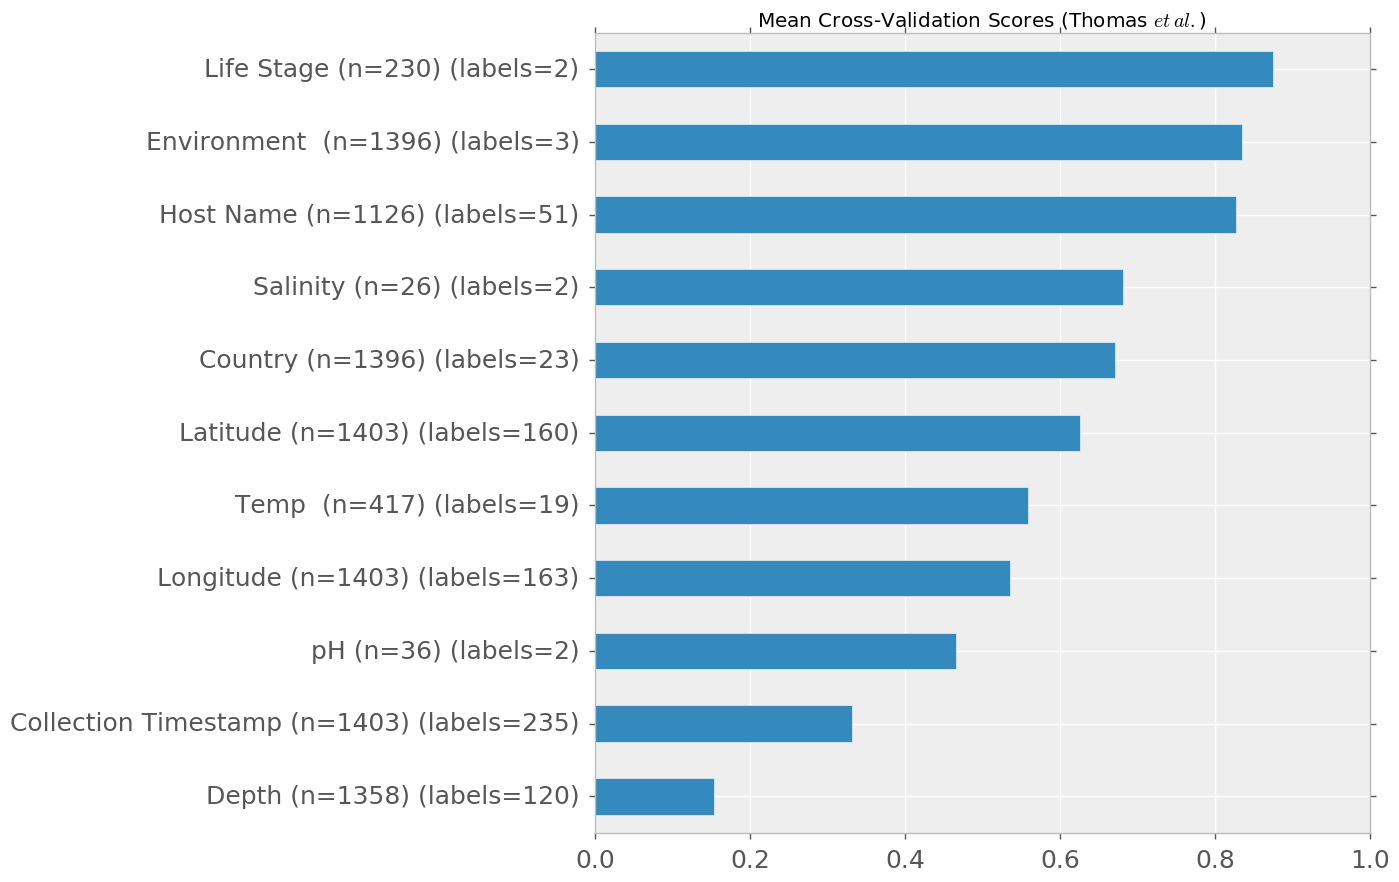

In [387]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1,figsize=(10,10))
scores.columns=['Matrix Completion (RF)']
scores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
scores=scores.T
#rename a few
scores=scores.T
scores.plot(kind='barh',title='Mean Cross-Validation Scores (Thomas $et \, al.$)',legend=False,fontsize=18,xlim=(0,1),ax=ax1)
ax1.set_ylabel('')
plt.show()

# Example: Learning Bacteria that Cause Variance Along Axis for pH

#### Recovering information about features from PCA eigenvectors  


### Suppose we would like to see how the bacteria chnage along this first axis of pH since our machine leanring identified that as the best catagory from the metadata.

### If the gradient change is along that axis we can then say what bacteria chnages the most along that axis.

### The priniple components are a linear combination of origonal features in N dimentional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are wieghts and $X_{N}$ is the origonal variables

#### Therefore the coefficients are the transfrom of an idenity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

# This time we do want to use PC-2

In [258]:
# View bacteria causing variance on the first axis
low_rank_matrix_plot=clr(low_rank_matrix+1)
#low_rank_matrix_plot=low_rank_matrix.copy()
low_rank_matrix_plot_matched,mappingdf_plot_matched = match(pd.DataFrame(low_rank_matrix_plot,otu.index.values,otu.columns.values).T,mappingdf[~mappingdf['Life Stage'].isin(['adult','Unknown'])]) #filter data for unknowns
otu_org_matrix_plot_matched,mappingdf_plot_matched = match(pd.DataFrame(otu.as_matrix(),otu.index.values,otu.columns.values).T,mappingdf[~mappingdf['Life Stage'].isin(['adult','Unknown'])]) #filter data for unknowns
bact_to_show=20 # number of bacteria to extract
niche_plot='Life Stage' # any column from mapping
Pc_plot="PC-2" # can be PC-2
imputed_in=low_rank_matrix_plot_matched.T.as_matrix().copy() # imputed data to use
cont=False # default true, false if not continous data
# Extract information from imputed PCA axis  
out_niche_linkeddf,observed_table_sfi,index_mean,index_std,highest_var_bact,pccompdf  = PCA_niche.niche_visual(otu_org_matrix_plot_matched.T,imputed_in,tax_index,bact_to_show,niche_plot,Pc_plot,mappingdf)

In [259]:
#PCA
observed_table_sfi, mapping = match(observed_table_sfi.T, mappingdf)
pca_model=PCA(n_components=2)
X2=observed_table_sfi.as_matrix()
X_reduced2 = pca_model.fit_transform(X2)
ids=['PC1','PC2']
spPCAplot=pd.DataFrame(X_reduced2,low_rank_matrix_plot_matched.index.values,ids)
spPCAplot['labels']=mappingdf_plot_matched['Life Stage']
#clean
index_mean_new=[]
index_std_new=[]
new_taxa=[]
#lowest taxaclassification + (phylum)
for nm in out_niche_linkeddf.index.values.tolist():
    #find lowest taxa level 
    q=0
    while q<(len(nm.split(';'))-1):
        lw=nm.split(';')[q]
        q+=1
        if len(nm.split(';')[q])==3 or '1'in nm.split(';')[q] or '2' in nm.split(';')[q]:
            break
    if '[' in lw.split('__')[1]:
        lw=lw.split('__')[1]
        lw=lw[1:-1]
    else:
        lw=lw.split('__')[1]  
    
    if 'std' in nm:
        index_std_new.append(lw+' ('+nm.split(';')[0].split('__')[1]+')'+'std')
        new_taxa.append(lw+' ('+nm.split(';')[0].split('__')[1]+')'+'std')
    else:
        index_mean_new.append(lw+' ('+nm.split(';')[0].split('__')[1]+')')
        new_taxa.append(lw+' ('+nm.split(';')[0].split('__')[1]+')')    
out_niche_linkeddf.index=new_taxa
out_niche_linkeddf=out_niche_linkeddf[out_niche_linkeddf.columns[::-1]]

# Visualize the figure

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


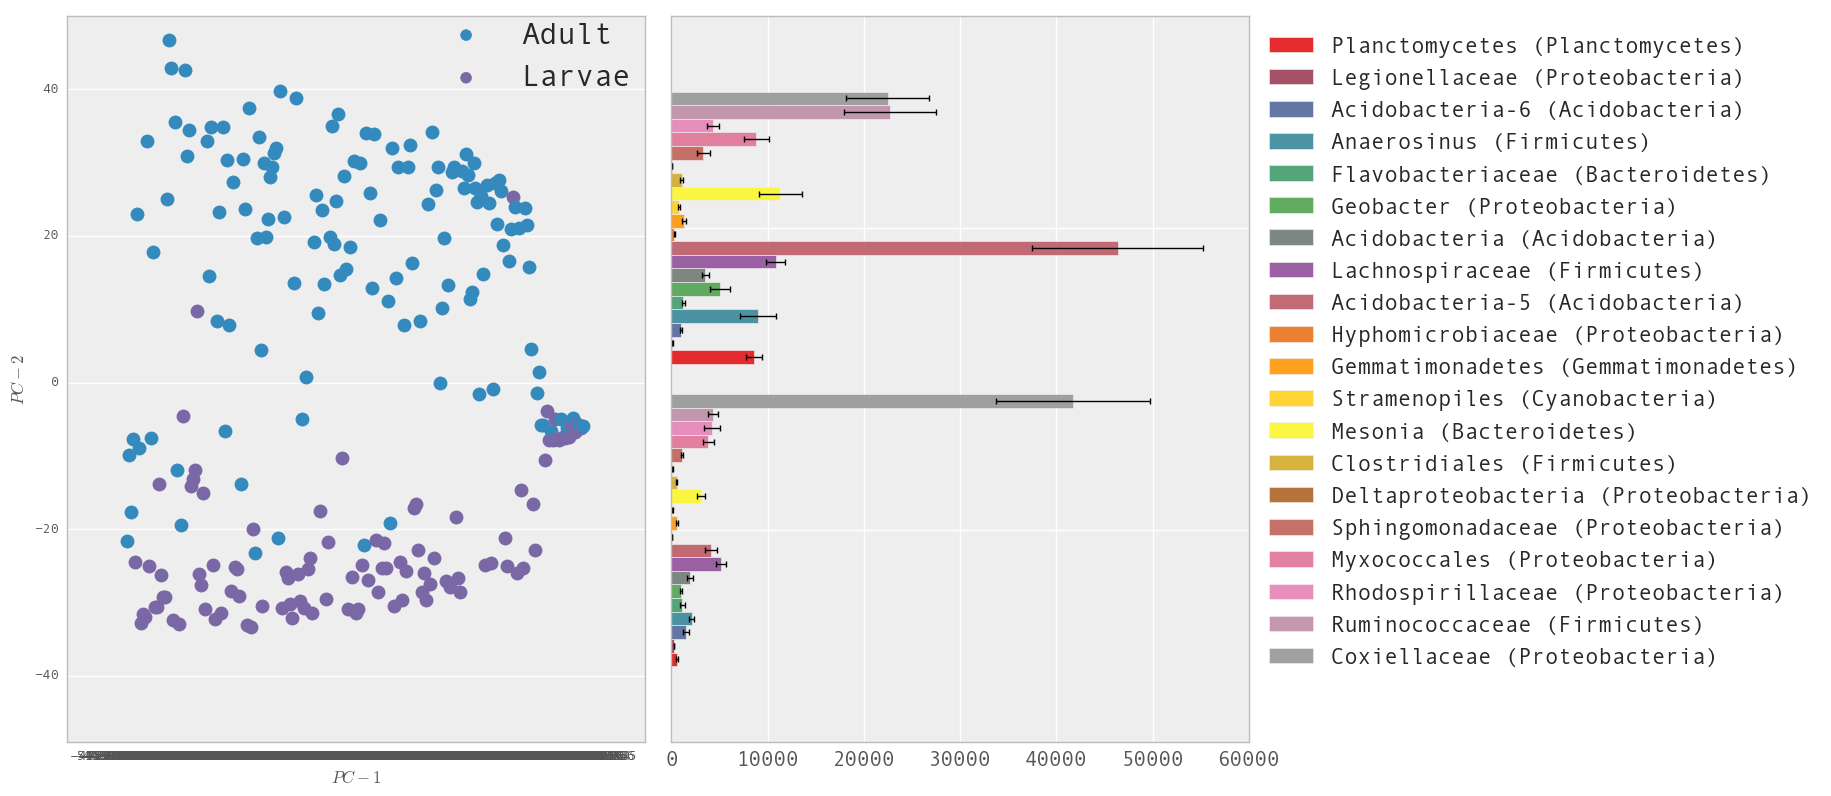

In [310]:
#plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(13, 8),sharey=False)
#scatter
sns.swarmplot(x="PC1", y="PC2", data=spPCAplot, hue="labels", size=10,ax=ax1)
ax1.set_xlabel('$PC-1$')
ax1.set_ylabel('$PC-2$')
ax1.legend(loc=2,prop={'size':22},bbox_to_anchor=(.59, 1.03))
ax1.set_ylim([-49,50])
ax1.set_xlim([-30,260])
#barh
out_niche_linkeddf.T[index_mean_new].plot(kind='barh',width=.9, xerr=out_niche_linkeddf.T[index_std_new].values.T, alpha = 0.92,error_kw=dict(elinewidth=1,capsize=2,barsabove=True,ecolor='k',ms=1, mew=1),rot=0,colormap="Set1",sharey=True,fontsize=15,ax=ax2)
ax2.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
fig.set_tight_layout(True)
plt.show()

# From this we can extract biological knowledge from the axis of the graph. Furthermore we have identified life stage as an importanr factor in sponge micorbiomes. 

### Also note in this example PC-1 would yield no salient information

In [214]:
plt.close('all')